# Testing different Hyperparameters

Lets say we're curious about __how different learning rates and different batch sizes affect our model's accuracy when restricted to 5 epochs__, and we want to build an experiment to test out these hyperparameters.

In this notebook, we'll walk through the following:

- use python to perform this experiment
- use the CLI to perform this experiment
- evalute the results using Pandas

---

In [1]:
import sys
sys.path.append("../")
import pandas as pd
import os
import seaborn as sns

from utils_ic import ic_root_path
from utils_ic.datasets import unzip_url, Urls, data_path
from utils_ic.benchmark import *
from utils_ic.datasets import unzip_urls

Lets download some data that we want to test on. To use the benchmarking tool for single label classification, we'll need to make sure that the data is stored such that images are sorted into their classes inside of a subfolder. In this notebook, we'll use the FridgeObjects dataset provided in `utils_ic.datasets.Urls`, which is stored in the correct format.

In [2]:
input_data = unzip_url(Urls.fridge_objects_path, exist_ok=True)

## Using Python

We start by creating the Benchmark object:

In [ ]:
benchmark = Benchmark()

Before we start testing, it's a good idea to see what the default parameters. We can use a the property `parameters` to easily see those default values.

In [ ]:
benchmark.parameters

Now that we know the defaults, we can pass it the parameters we want to benchmark. 

In this notebook, we want to see the effect of different learning rates across different batch sizes using only 5 epochs (the default number of epochs is 15). To do so, I would run the `update_parameters` functions as follows:

```python
benchmark.update_parameters(learning_rate=[1e-3, 1e-4], batch_size=[8, 16, 32], epochs=[5])
```

Notice that all parameters must be passed in as a list, including single values such as `epochs=[5]`.

These parameters will be used to calculate the number of permutations to run. In this case, we've passed in `learning_rate=[1e-3, 1e-4]`, `batch_size=[8, 16, 32]`, and `epochs=[5]`. This will result in 2 X 3 X 1 total permutations (in otherwords, 6 permutations). 

In [ ]:
benchmark.update_parameters(learning_rate=[1e-3, 1e-4], batch_size=[8, 16, 32], epochs=[5])

Now that we have our parameters defined, we call the `run()` function with the dataset to test on. 

We can also optionally pass in:
- the number of repetitions to run each permutation (default is 3)
- whether or not we want the training to stop early if the metric (accuracy) doesn't improve by 0.01 (1%) over 3 epochs (default is False)

The `run` function returns a multi-index dataframe which we can work with right away.

In [ ]:
df = benchmark.run(datasets=[input_data], reps=2); df

## Using the CLI tool to benchmark

Instead of using python to run this experiment, we may want to test from the CLI. We can do so by using the `scripts/benchmark.py` file. 

First we move up to the `/image_classification` directory.

In [3]:
os.chdir(ic_root_path())

To reproduce the same test (different learning rates across different batch sizes using only 5 epochs), and the same settings (datasets in 'tmp_data', 3 repetitions, and no early_stopping) we can run the following:

```sh
python scripts/benchmark.py 
    --learning-rates 1e-3 1e-4 
    --batch-sizes 8 16 32 
    --epochs 5 
    --repeat 3 
    --no-early-stopping 
    --inputs <my-data-dir>
    --output lr_bs_test.csv
```

Additionally, we've added an output parameter, which will automatically dump our dataframe into a csv file.

To simplify the command, we can use the acryonyms of the params. We can also remove `--no-early-stopping` as that is the default behavior.

```sh
python scripts/benchmark.py -lr 1e-3 1e-4 -bs 8 16 32 -e 5 -r 3 -i <my-data-dir> -o lr_bs_test.csv
```

HINT: You can learn more about how to use the script: `python script/benchmark.py --help`

In [4]:
# use {sys.executable} instead of just running `python` to ensure the command is executed using the environment cvbp
!{sys.executable} scripts/benchmark.py -l 1e-3 1e-4 -bs 8 16 32 -e 5 -i {input_data} -o data/lr_bs_test.csv

{'learning_rate': [0.0001], 'epochs': [15], 'batch_size': [16], 'im_size': [299], 'architecture': [<Architecture.resnet18: functools.partial(<function resnet18 at 0x7f43c00d88c8>)>], 'transform': [True], 'dropout': [0.5], 'weight_decay': [0.01], 'training_schedule': [<TrainingSchedule.head_first_then_body: 3>], 'discriminative_lr': [True], 'one_cycle_policy': [True]}
{'learning_rate': [0.001, 0.0001], 'epochs': [5], 'batch_size': [8, 16, 32], 'im_size': [299], 'architecture': [<Architecture.resnet18: functools.partial(<function resnet18 at 0x7f43c00d88c8>)>], 'transform': [True], 'dropout': [0.5], 'weight_decay': [0.01], 'training_schedule': [<TrainingSchedule.head_first_then_body: 3>], 'discriminative_lr': [True], 'one_cycle_policy': [True]}
Running 1 of 6 permutations.Repeat 1 of 3.
epoch     train_loss  valid_loss  accuracy  time    
0         1.455754    1.067410    0.590909  00:01                    
Total time: 00:01
epoch     train_loss  valid_loss  accuracy  time    
0         

3         0.372149    0.708835    0.840909  00:01                  
Total time: 00:06
Running 3 of 6 permutations.Repeat 3 of 3.       
epoch     train_loss  valid_loss  accuracy  time    
0         1.950184    1.404315    0.204545  00:02                  
Total time: 00:02
epoch     train_loss  valid_loss  accuracy  time    
0         1.752094    0.973326    0.727273  00:01                  
1         1.116722    0.540867    0.818182  00:01                  
2         0.805669    0.661786    0.681818  00:01                  
3         0.625847    0.504913    0.795455  00:02                  
Total time: 00:07
Running 4 of 6 permutations.Repeat 3 of 3.       
epoch     train_loss  valid_loss  accuracy  time    
0         1.815813    1.539662    0.204545  00:01                    
Total time: 00:01
epoch     train_loss  valid_loss  accuracy  time    
0         1.415985    0.490635    0.931818  00:01                    
1         0.882690    0.089884    0.977273  00:01                   

Once the script completes, load the csv into a dataframe to explore it's contents. We'll want to specify `index_col=[0, 1, 2]` since it is a multi-index dataframe.

In [4]:
df = pd.read_csv("data/lr_bs_test.csv", index_col=[0, 1, 2]); df

duration  \
0 PARAMETERS [learning_rate: 0.0001]|[epochs: 5]|... fridgeObjects   8.651757   
  PARAMETERS [learning_rate: 0.0001]|[epochs: 5]|... fridgeObjects  10.965223   
  PARAMETERS [learning_rate: 0.0001]|[epochs: 5]|... fridgeObjects   7.972936   
  PARAMETERS [learning_rate: 0.001]|[epochs: 5]|[... fridgeObjects   9.072790   
  PARAMETERS [learning_rate: 0.001]|[epochs: 5]|[... fridgeObjects  11.183764   
  PARAMETERS [learning_rate: 0.001]|[epochs: 5]|[... fridgeObjects  12.447375   
1 PARAMETERS [learning_rate: 0.0001]|[epochs: 5]|... fridgeObjects   8.753763   
  PARAMETERS [learning_rate: 0.0001]|[epochs: 5]|... fridgeObjects  10.940783   
  PARAMETERS [learning_rate: 0.0001]|[epochs: 5]|... fridgeObjects   8.146652   
  PARAMETERS [learning_rate: 0.001]|[epochs: 5]|[... fridgeObjects   8.670103   
  PARAMETERS [learning_rate: 0.001]|[epochs: 5]|[... fridgeObjects  10.917396   
  PARAMETERS [learning_rate: 0.001]|[epochs: 5]|[... fridgeObjects   7.968576   
2 PARAMETERS [learning_rate: 0.0001]|[epochs: 5]|... fridgeObjects   8.751582   
  PARAMETERS [learning_rate: 0.0001]|[epochs: 5]|... fridgeObjects  10.881367   
  PARAMETERS [learning_rate: 0.0001]|[epochs: 5]|... fridgeObjects   8.192488   
  PARAMETERS [learning_rate: 0.001]|[epochs: 5]|[... fridgeObjects   8.778858   
  PARAMETERS [learning_rate: 0.001]|[epochs: 5]|[... fridgeObjects  11.057554   
  PARAMETERS [learning_rate: 0.001]|[epochs: 5]|[... fridgeObjects   8.097866   

                                                                    accuracy  
0 PARAMETERS [learning_rate: 0.0001]|[epochs: 5]|... fridgeObjects  0.954545  
  PARAMETERS [learning_rate: 0.0001]|[epochs: 5]|... fridgeObjects  0.954545  
  PARAMETERS [learning_rate: 0.0001]|[epochs: 5]|... fridgeObjects  0.977273  
  PARAMETERS [learning_rate: 0.001]|[epochs: 5]|[... fridgeObjects  0.954545  
  PARAMETERS [learning_rate: 0.001]|[epochs: 5]|[... fridgeObjects  0.840909  
  PARAMETERS [learning_rate: 0.001]|[epochs: 5]|[... fridgeObjects  0.886364  
1 PARAMETERS [learning_rate: 0.0001]|[epochs: 5]|... fridgeObjects  0.954545  
  PARAMETERS [learning_rate: 0.0001]|[epochs: 5]|... fridgeObjects  0.977273  
  PARAMETERS [learning_rate: 0.0001]|[epochs: 5]|... fridgeObjects  0.977273  
  PARAMETERS [learning_rate: 0.001]|[epochs: 5]|[... fridgeObjects  0.818182  
  PARAMETERS [learning_rate: 0.001]|[epochs: 5]|[... fridgeObjects  0.909091  
  PARAMETERS [learning_rate: 0.001]|[epochs: 5]|[... fridgeObjects  0.772727  
2 PARAMETERS [learning_rate: 0.0001]|[epochs: 5]|... fridgeObjects  0.954545  
  PARAMETERS [learning_rate: 0.0001]|[epochs: 5]|... fridgeObjects  0.977273  
  PARAMETERS [learning_rate: 0.0001]|[epochs: 5]|... fridgeObjects  1.000000  
  PARAMETERS [learning_rate: 0.001]|[epochs: 5]|[... fridgeObjects  0.840909  
  PARAMETERS [learning_rate: 0.001]|[epochs: 5]|[... fridgeObjects  0.795455  
  PARAMETERS [learning_rate: 0.001]|[epochs: 5]|[... fridgeObjects  0.795455

---

## Visualizing our results

When we read in out multi-index dataframe, index 0 represents the run number, index 1 represents a single permutation of parameters, and index 2 represents the dataset.

To see the results, show the df using the `clean_df` helper function. This will display all the hyperparameters in a nice, readable way.

In [5]:
df = clean_df(df); df 

duration  accuracy
0 [learning_rate: 0.0001] [batch_size: 16] fridgeObjects   8.651757  0.954545
  [learning_rate: 0.0001] [batch_size: 32] fridgeObjects  10.965223  0.954545
  [learning_rate: 0.0001] [batch_size: 8]  fridgeObjects   7.972936  0.977273
  [learning_rate: 0.001] [batch_size: 16]  fridgeObjects   9.072790  0.954545
  [learning_rate: 0.001] [batch_size: 32]  fridgeObjects  11.183764  0.840909
  [learning_rate: 0.001] [batch_size: 8]   fridgeObjects  12.447375  0.886364
1 [learning_rate: 0.0001] [batch_size: 16] fridgeObjects   8.753763  0.954545
  [learning_rate: 0.0001] [batch_size: 32] fridgeObjects  10.940783  0.977273
  [learning_rate: 0.0001] [batch_size: 8]  fridgeObjects   8.146652  0.977273
  [learning_rate: 0.001] [batch_size: 16]  fridgeObjects   8.670103  0.818182
  [learning_rate: 0.001] [batch_size: 32]  fridgeObjects  10.917396  0.909091
  [learning_rate: 0.001] [batch_size: 8]   fridgeObjects   7.968576  0.772727
2 [learning_rate: 0.0001] [batch_size: 16] fridgeObjects   8.751582  0.954545
  [learning_rate: 0.0001] [batch_size: 32] fridgeObjects  10.881367  0.977273
  [learning_rate: 0.0001] [batch_size: 8]  fridgeObjects   8.192488  1.000000
  [learning_rate: 0.001] [batch_size: 16]  fridgeObjects   8.778858  0.840909
  [learning_rate: 0.001] [batch_size: 32]  fridgeObjects  11.057554  0.795455
  [learning_rate: 0.001] [batch_size: 8]   fridgeObjects   8.097866  0.795455

Since we've run our benchmarking over 3 repetitions, we may want to just look at the averages across the different __run numbers__.

In [6]:
df.mean(level=(1,2)).T

,[learning_rate: 0.0001] [batch_size: 16],[learning_rate: 0.0001] [batch_size: 32],[learning_rate: 0.0001] [batch_size: 8],[learning_rate: 0.001] [batch_size: 16],[learning_rate: 0.001] [batch_size: 32],[learning_rate: 0.001] [batch_size: 8]
,fridgeObjects,fridgeObjects,fridgeObjects,fridgeObjects,fridgeObjects,fridgeObjects
duration,8.719034,10.929124,8.104025,8.840584,11.052905,9.504606
accuracy,0.954545,0.969697,0.984849,0.871212,0.848485,0.818182


Additionally, we may want simply to see which set of hyperparameters perform the best across the different __datasets__. We can do that by averaging the results of the different datasets. (The results of this step will look similar to the above since we're only passing in one dataset).

In [7]:
df.mean(level=(1)).T

,[learning_rate: 0.0001] [batch_size: 16],[learning_rate: 0.0001] [batch_size: 32],[learning_rate: 0.0001] [batch_size: 8],[learning_rate: 0.001] [batch_size: 16],[learning_rate: 0.001] [batch_size: 32],[learning_rate: 0.001] [batch_size: 8]
duration,8.719034,10.929124,8.104025,8.840584,11.052905,9.504606
accuracy,0.954545,0.969697,0.984849,0.871212,0.848485,0.818182


To make it easier to see which permutation did the best, we can plot the results using the `plot_df` helper function.

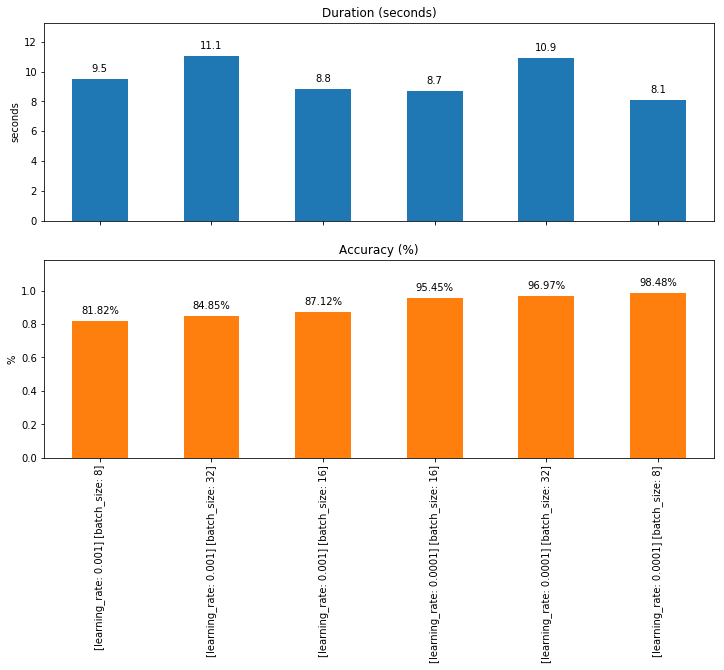

In [8]:
plot_df(df.mean(level=(1)), sort_by="accuracy")

---

## Clean up

Clean up the data directory we created since we've finished with our benchmarks.

In [ ]:
shutil.rmtree("tmp_data")